In [43]:
#carregando os dados e os estruturando...

import tensorflow as tf
import os

# # Baixar e preparar os diretórios (só é necessário se os dados não estiverem salvos localmente ainda)
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname("/home/nathannss/.keras/datasets/"), 'cats_and_dogs_extracted', 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Recriar datasets a partir das pastas
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Dividir o validation_dataset original para recriar o test_dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Otimização (opcional)
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 1000 files belonging to 2 classes.


In [44]:
# Carregando o modelo
from keras.layers import TFSMLayer

# Substitua o caminho pelo seu diretório SavedModel
model = TFSMLayer('./recognition_cat_dog_model', call_endpoint='serving_default')


In [45]:
# Cálculos para criar a matriz de confusão do modelo

import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    instPreds = model(images)
    preds_tf = instPreds['output_0']
    
    preds = (preds_tf.numpy() > 0.5).astype(int)

    y_true.extend(labels.numpy().flatten())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

VP = np.sum((y_true == 1) & (y_pred == 1))
VN = np.sum((y_true == 0) & (y_pred == 0))
FP = np.sum((y_true == 0) & (y_pred == 1))
FN = np.sum((y_true == 1) & (y_pred == 0))



In [46]:
# Calculo das Métricas

SENSIBILIDADE = VP / (VP + FN)
ESPECIFICIDADE = VN / (FP + VN)
ACURACIA = (VP + VN) / VP + VN + FP + FN
PRECISAO = VP / (VP + FP)
F_SCORE = 2 * (PRECISAO * SENSIBILIDADE) / PRECISAO + SENSIBILIDADE


          Métrica       Valor
0        Acurácia  101.010753
1        Precisão    0.978947
2   Sensibilidade    0.968750
3  Especificidade    0.979167
4        F1-Score    2.906250


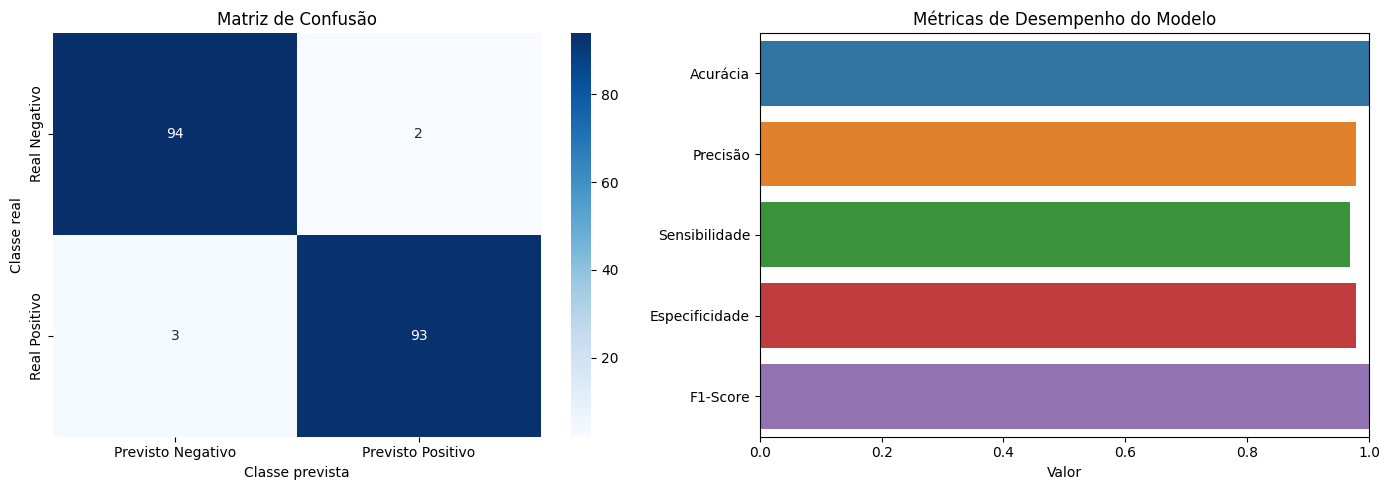

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cm = np.array([[VN, FP],
               [FN, VP]])

# DataFrame das métricas
df = pd.DataFrame({
    "Métrica": ["Acurácia", "Precisão", "Sensibilidade", "Especificidade", "F1-Score"],
    "Valor": [ACURACIA, PRECISAO, SENSIBILIDADE, ESPECIFICIDADE, F_SCORE]
})

# Criar os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 linha, 2 colunas

# 🔹 Heatmap da matriz de confusão
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Previsto Negativo", "Previsto Positivo"],
            yticklabels=["Real Negativo", "Real Positivo"],
            ax=axes[0])
axes[0].set_xlabel("Classe prevista")
axes[0].set_ylabel("Classe real")
axes[0].set_title("Matriz de Confusão")

# 🔸 Gráfico de barras das métricas
sns.barplot(y="Métrica", x="Valor", data=df, hue="Métrica", legend=False, ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].set_title("Métricas de Desempenho do Modelo")
axes[1].set_xlabel("Valor")
axes[1].set_ylabel("")

# Ajustar o layout
print(df)
plt.tight_layout()
plt.show()